In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor


In [3]:
data = pd.read_csv('/Users/bibhusundarmohapatra/Downloads/cleanliness_scores_with_revised_ids.csv')

In [5]:
data

,_id,postOfficeId,responseTime,percentageOrganicWaste,quantity.frequency.plastic,quantity.frequency.biodegradable,quantity.frequency.metal,quantity.frequency.paper,quantity.frequency.cardboard,quantity.frequency.glass,quantity.size,quantity.totalCount,imageUrl,score,time,__v,quantity.spit,spit,Area
0,675202631b327ab087228d76,64c9da1bcef89213fa034dba,1970-01-01T00:00:00.000Z,17,12,5.0,0,2,10.0,0.0,large,29,http://localhost:8000/static/annotated_2024120...,14.63,2024-12-05T19:43:31.824Z,0,6,0,footpath
1,6752027b1b327ab087228d7a,92e1ab3fcdba428ef012adbc,1970-01-01T00:00:00.000Z,17,12,5.0,0,2,10.0,0.0,large,29,http://localhost:8000/static/annotated_2024120...,14.63,2024-12-05T19:43:55.460Z,0,5,2,footpath
2,675202a9fb5872f27f793ed3,92e1ab3fcdba428ef012adbc,1970-01-01T00:00:00.000Z,17,12,5.0,0,2,10.0,0.0,large,29,http://localhost:8000/static/annotated_2024120...,14.63,2024-12-05T19:44:41.622Z,0,3,1,footpath
3,675202d012077be89860e1f6,89b412fdcda823ac9012efba,1970-01-01T00:00:00.000Z,17,12,5.0,0,2,10.0,0.0,large,29,http://localhost:8000/static/annotated_2024120...,14.63,2024-12-05T19:45:20.259Z,0,3,3,footpath
4,6752032512077be89860e1fa,47bcde2afa8903efc1ba2341,1970-01-01T00:00:00.000Z,0,0,0.0,0,0,0.0,0.0,small,0,http://localhost:8000/static/annotated_2024120...,0.00,2024-12-05T19:46:45.278Z,0,7,3,footpath
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264,677268f,89b412fdcda823ac9012efba,2024-03-17T07:29:57.000Z,15,12,5.0,1,13,20.0,6.0,Large,55,http://localhost:8000/static/annotated_image.jpg,5.83,2024-04-14T04:20:31.000Z,4,7,1,road
265,448563a,601f4edbcd674cda9810efb6,2024-03-07T23:07:15.000Z,85,13,12.0,17,12,20.0,11.0,Large,58,http://localhost:8000/static/annotated_image.jpg,18.17,2024-09-05T19:59:26.000Z,5,4,4,footpath
266,494553b,89b412fdcda823ac9012efba,2024-03-19T11:57:55.000Z,78,18,8.0,1,10,3.0,5.0,Small,46,http://localhost:8000/static/annotated_image.jpg,31.45,2024-05-14T21:39:34.000Z,2,6,1,parks
267,282786e,5431cdaedbc251bc8345feca,2024-04-18T22:48:12.000Z,94,7,9.0,0,16,5.0,5.0,Medium,43,http://localhost:8000/static/annotated_image.jpg,47.03,2024-12-23T21:23:37.000Z,1,0,0,garden


In [3]:
for col in ['quantity.frequency.biodegradable', 'quantity.frequency.cardboard', 'quantity.frequency.glass']:
    data[col] = data[col].fillna(data[col].mean())


data['time'] = pd.to_datetime(data['time'])
data['hour'] = data['time'].dt.hour
data['day'] = data['time'].dt.day
data['month'] = data['time'].dt.month
data['day_of_week'] = data['time'].dt.dayofweek

In [4]:
label_encoders = {}
categorical_cols = ['Area', 'quantity.size']
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

In [5]:
irrelevant_cols = ['_id', 'postOfficeId', 'responseTime', 'imageUrl', 'time']
data = data.drop(columns=irrelevant_cols)

In [6]:
X = data.drop(columns=['score'])
y = data['score']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
# Train XGBoost Regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)

# Train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Combine Predictions Using Averaging
y_pred_xgb = xgb_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

# Weighted Average of Predictions
final_predictions = 0.6 * y_pred_xgb + 0.4 * y_pred_rf

In [9]:
rmse = np.sqrt(mean_squared_error(y_test, final_predictions))
print(f'RMSE of Combined Model: {rmse}')

RMSE of Combined Model: 24.417751944285015


<Figure size 1000x500 with 0 Axes>

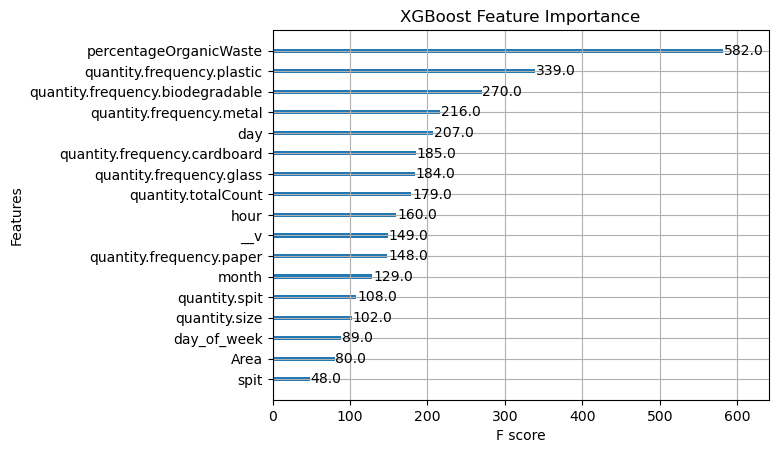

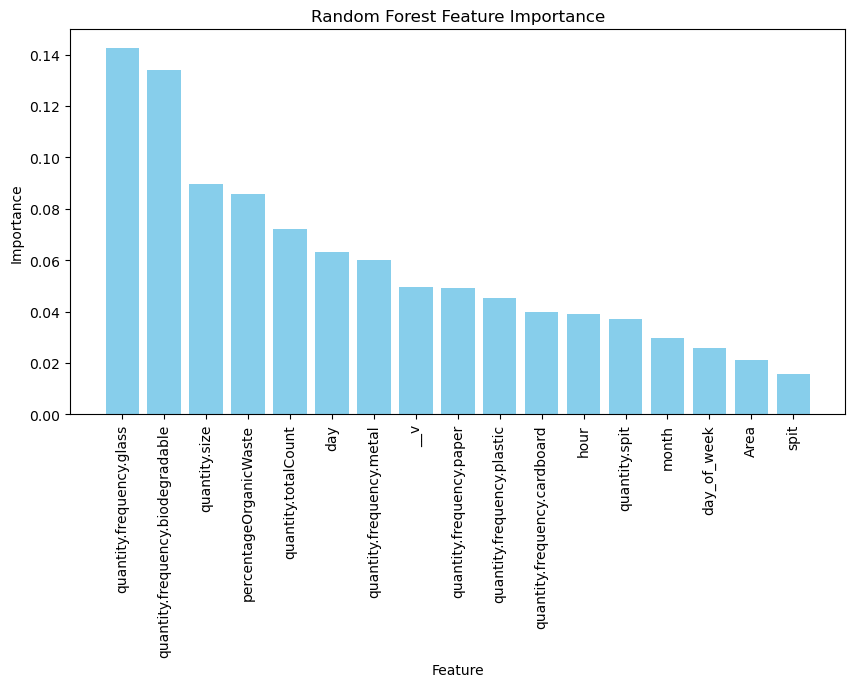

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
xgb.plot_importance(xgb_model, importance_type='weight', title="XGBoost Feature Importance")
plt.show()

# Feature Importance for Random Forest
importances = rf_model.feature_importances_
rf_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Plot Random Forest Feature Importance
plt.figure(figsize=(10, 5))
plt.bar(rf_importances['Feature'], rf_importances['Importance'], color='skyblue')
plt.title("Random Forest Feature Importance")
plt.xticks(rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

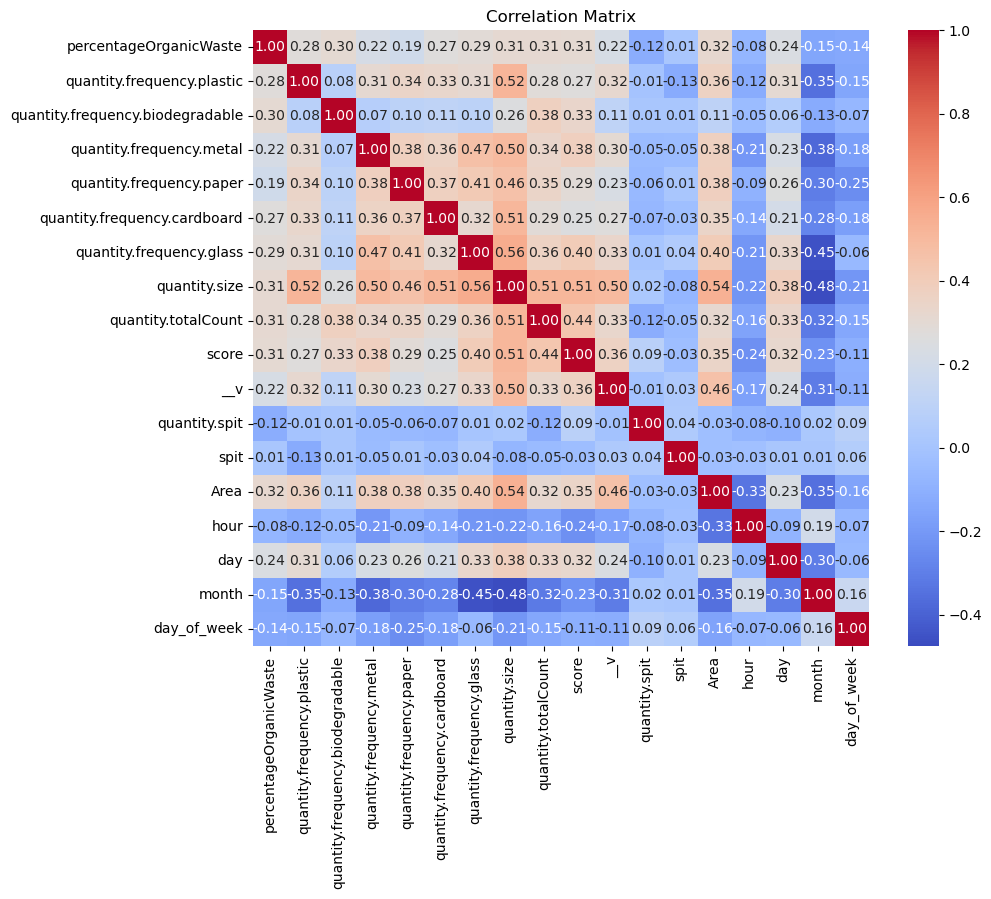

                                  percentageOrganicWaste  \
percentageOrganicWaste                          1.000000   
quantity.frequency.plastic                      0.276919   
quantity.frequency.biodegradable                0.303716   
quantity.frequency.metal                        0.219696   
quantity.frequency.paper                        0.189879   
quantity.frequency.cardboard                    0.272854   
quantity.frequency.glass                        0.289503   
quantity.size                                   0.311077   
quantity.totalCount                             0.312600   
score                                           0.306482   
__v                                             0.222921   
quantity.spit                                  -0.115992   
spit                                            0.009942   
Area                                            0.316820   
hour                                           -0.076760   
day                                     

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Generate correlation matrix for numerical columns
correlation_matrix = data.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, square=True)
plt.title("Correlation Matrix")
plt.show()

# Print the correlation matrix
print(correlation_matrix)

Correlation of 'score' with other features:
score                               1.000000
quantity.size                       0.514397
quantity.totalCount                 0.439745
quantity.frequency.glass            0.403334
quantity.frequency.metal            0.377833
__v                                 0.360780
Area                                0.348053
quantity.frequency.biodegradable    0.331813
day                                 0.324477
percentageOrganicWaste              0.306482
quantity.frequency.paper            0.287033
quantity.frequency.plastic          0.271270
quantity.frequency.cardboard        0.253727
quantity.spit                       0.085476
spit                               -0.031975
day_of_week                        -0.108928
month                              -0.231968
hour                               -0.235733
Name: score, dtype: float64


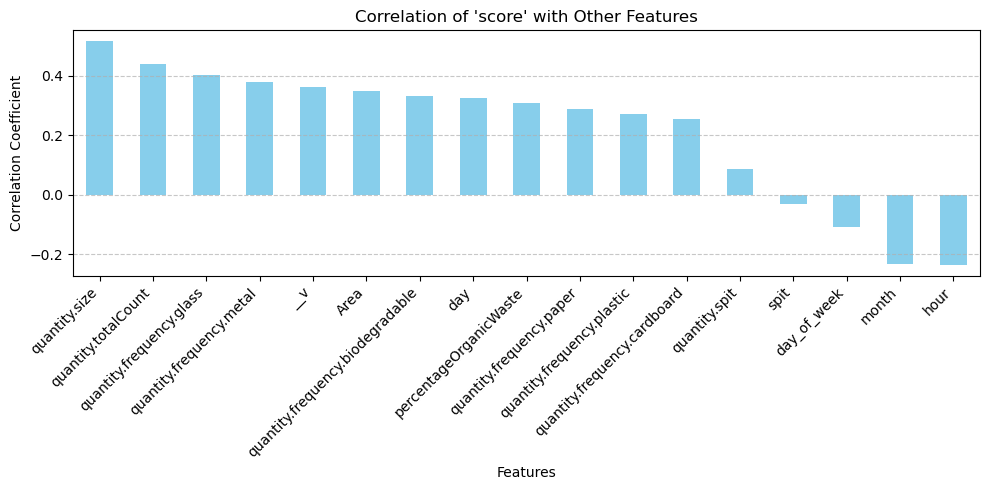

In [14]:
# Compute correlation of 'score' with other features
score_correlation = data.corr()['score'].sort_values(ascending=False)

# Print the correlations
print("Correlation of 'score' with other features:")
print(score_correlation)



plt.figure(figsize=(10, 5))
score_correlation.drop('score').plot(kind='bar', color='skyblue')  # Exclude self-correlation
plt.title("Correlation of 'score' with Other Features")
plt.xlabel("Features")
plt.ylabel("Correlation Coefficient")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [15]:
from sklearn.linear_model import LinearRegression

In [21]:
selected_features = [
    'quantity.size',  'quantity.frequency.glass',
    'quantity.frequency.metal', 'quantity.frequency.biodegradable',
    'percentageOrganicWaste', 'quantity.frequency.paper', 'quantity.frequency.plastic',
    'quantity.frequency.cardboard', 'quantity.spit'
]

In [22]:
X = data[selected_features] 
y = data['score']

In [23]:
model = LinearRegression()
model.fit(X, y)


LinearRegression()

In [24]:
intercept = model.intercept_
coefficients = model.coef_


In [25]:
features = X.columns
formula = f"score = {intercept:.2f}"
for feature, coef in zip(features, coefficients):
    formula += f" + ({coef:.2f} * {feature})"

# Print the formula
print("Generated Formula:")
print(formula)

Generated Formula:
score = -11.68 + (2.09 * quantity.size) + (0.60 * quantity.frequency.glass) + (0.72 * quantity.frequency.metal) + (0.60 * quantity.frequency.biodegradable) + (0.10 * percentageOrganicWaste) + (0.13 * quantity.frequency.paper) + (-0.04 * quantity.frequency.plastic) + (-0.21 * quantity.frequency.cardboard) + (1.11 * quantity.spit)
